# K-means clustering analysis for stocks compiled in the Hang Sang Index
The goal of this demo is to show how we can apply k-means clustering to identify market patterns and analyze their relationships not only among the clusters themselves but also with the market's trend. Specifically, we first cluster on 48 different stocks as similar to building a dictionary in Bag-of-Words. Then, we construct a matrix on the transition between the clusters themselves and identify trending behavior among the clusters and the next $n-$day trend

In [1]:
import os
import glob
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import utils
import ta_utils as ta
import candlesticks_plot as cp
% matplotlib inline

from collections import Counter
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

Defining a 6-day window on the daily OHLC prices for 48 different stocks

In [2]:
window = 6
path = glob.glob('./stockData/*')
data = [pd.read_csv(filename).drop(columns=['Volume','Date']) for filename in path]
lag_data = [utils.n_day_lag(d, window).dropna() for d in data]
trend_data = [utils.get_window_trend(d, window).dropna() for d in data]
# data = pd.concat(data).reset_index(drop=True)

Whitening data and initializing clusters. Our goal is to identify 24 different clusters.

In [3]:
K = 24
pca = PCA()
X = pca.fit_transform(pd.concat(lag_data,axis=0))
centroids = np.random.normal(size=(K,X.shape[1]))
centroids = (centroids - centroids.mean()) / centroids.std()
km = KMeans(n_clusters=K, init=centroids)
km.fit(X)

/usr/local/lib/python2.7/dist-packages/sklearn/cluster/k_means_.py:896: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)


KMeans(algorithm='auto', copy_x=True,
    init=array([[ 9.70762e-01, -6.07408e-01, ..., -4.09399e-01, -2.45121e+00],
       [-8.71682e-01,  3.91857e-02, ..., -2.07424e-01,  4.95899e-01],
       ...,
       [-7.49700e-01, -1.08511e-01, ..., -1.38248e+00,  1.27265e+00],
       [-5.88138e-01,  2.05282e-01, ..., -2.39347e-03, -2.36252e-01]]),
    max_iter=300, n_clusters=24, n_init=10, n_jobs=1,
    precompute_distances='auto', random_state=None, tol=0.0001, verbose=0)

Visualizing distribution of clusters

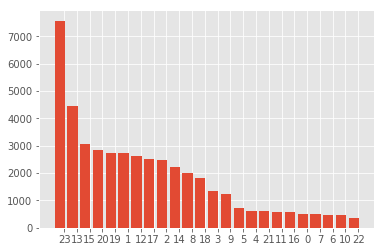

In [4]:
counts = Counter(km.labels_)
plt.style.use('ggplot')
labels, values = zip(*counts.items())
# sort your values in descending order
indSort = np.argsort(values)[::-1]
# rearrange your data
labels = np.array(labels)[indSort]
values = np.array(values)[indSort]
indexes = np.arange(len(labels))
bar_width = 0.35
plt.bar(indexes, values)
# add labels
plt.xticks(indexes + bar_width, labels)
plt.show()

After identifying our clusters, we apply this on selected stocks to analyze the patterns we have idenfified. As examples, we will use the daily prices for HSBC and MTR

In [5]:
hsbc_ohlc = pd.read_csv('./data/0005.HK.csv')
hsbc_ohlc = hsbc_ohlc.set_index('Date')
hsbc_ohlc = hsbc_ohlc.drop(columns=['Volume'])
hsbc_ohlc_lag = utils.n_day_lag(hsbc_ohlc, window).dropna()
hsbc_trend = utils.get_window_trend(hsbc_ohlc, window).dropna()
hsbc_clusters = km.predict(PCA().fit_transform(hsbc_ohlc_lag.as_matrix()))
hsbc_clusters = pd.Series(hsbc_clusters, name='Cluster', index=hsbc_trend.index)
cluster_trend = pd.concat([hsbc_clusters, hsbc_trend],axis=1)

mtr_ohlc = pd.read_csv('./data/0066.HK.csv')
mtr_ohlc = mtr_ohlc.set_index('Date')
mtr_ohlc = mtr_ohlc.drop(columns=['Volume'])
mtr_ohlc_lag = utils.n_day_lag(mtr_ohlc, window).dropna()
mtr_trend = utils.get_window_trend(mtr_ohlc, window)
mtr_clusters = km.predict(PCA().fit_transform(mtr_ohlc_lag.as_matrix()))
mtr_clusters = pd.Series(mtr_clusters, name='Cluster', index=mtr_trend.index)
mtr_cluster_trend = pd.concat([mtr_clusters, mtr_trend],axis=1)

Using the prices of HSBC, we identfy the transition from one cluster to another. Specifically, the transition probabilities is represented in matrix $\mathbb{P}=\{p_{i,j}\}_{i,j\in\mathbb{N}}$ where $p_{i,j}$ is the probability of transitioning from cluster $i$ to cluster $j$. Given cluster $i$ at time $t$ $c_t^i$, the transition probability $p_{i,j}=p(c_{t+5}^j|c_t^i)$ for $t=1,2,3,...$.

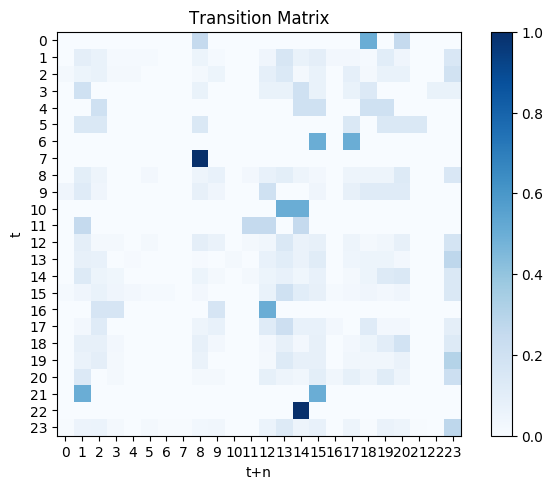

In [6]:
plt.style.use('default')
trans_mat = utils.transition_matrix(hsbc_clusters, K, future_step=window)
cp.plot_heatmap(trans_mat, K, show_prob=False)

We are interested in whether there is a relationship between clusters and the window it is defined in. Here, we plot the probability of a cluster that is defined as a trend: bullish (1), no-trend (0), and bearish (-1)

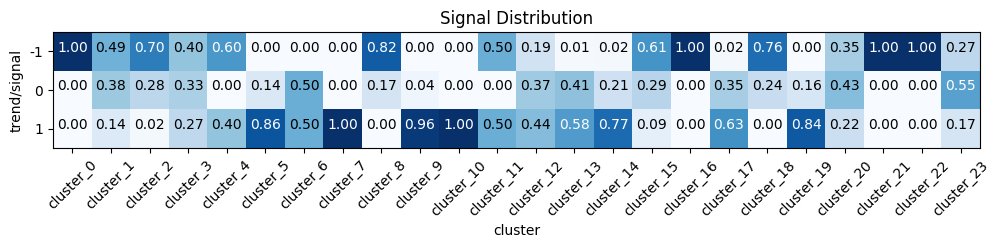

In [7]:
sig_dist = utils.trend_cluster_distribution(cluster_trend, K)
plt.figure(figsize=(10,10))
cp.plot_signal_distribution(sig_dist)

Simiarly for MTR, we plot the same heatmap and compare the two:

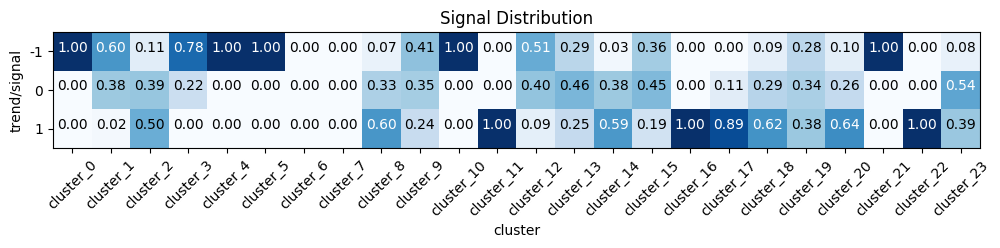

In [8]:
sig_dist = utils.trend_cluster_distribution(mtr_cluster_trend.dropna(), K)
plt.figure(figsize=(10,10))
cp.plot_signal_distribution(sig_dist)

We can further examine the market trend for the next $n-$day. Here we make similar plots as above for the next 3-day trend for HSBC:

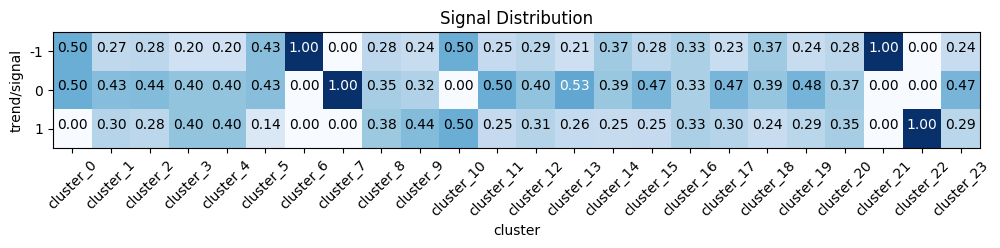

In [9]:
window = 3
hsbc_trend = utils.get_n_day_trend(hsbc_ohlc, window).dropna()
cluster_trend = pd.concat([hsbc_clusters, hsbc_trend],axis=1)
sig_dist = utils.trend_cluster_distribution(cluster_trend.dropna(), K)
plt.figure(figsize=(10,10))
cp.plot_signal_distribution(sig_dist)

and simiarly for MTR:

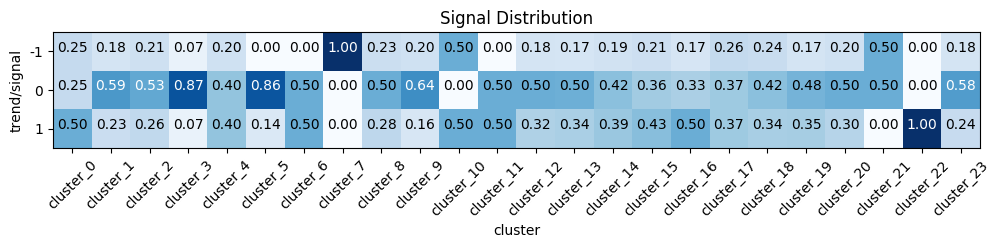

In [10]:
mtr_trend = utils.get_n_day_trend(mtr_ohlc, window).dropna()
mtr_cluster_trend = pd.concat([hsbc_clusters, mtr_trend],axis=1)
sig_dist = utils.trend_cluster_distribution(mtr_cluster_trend.dropna(), K)
plt.figure(figsize=(10,10))
cp.plot_signal_distribution(sig_dist)

In [12]:
#output demo
import os
os.system('jupyter nbconvert --to html kmeans-demo.ipynb')

0